In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
train_dataset = datasets.ImageFolder(root='/kaggle/input/dl-challenge/dl2425_challenge_dataset/train/', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='/kaggle/input/dl-challenge/dl2425_challenge_dataset/val/', transform=val_transforms)

In [8]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [10]:
print(train_dataset.class_to_idx)

{'0': 0, '1': 1}


In [11]:
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
#try lr = 1e-4, 1e-5, 1e-6

In [16]:
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Reshape labels for BCEWithLogitsLoss
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')
    
    # Validation step
    model.eval()
    val_running_loss = 0.0
    correct_predictions = 0
    
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.float().unsqueeze(1).to(device)
            
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            
            val_running_loss += val_loss.item() * val_images.size(0)
            
            # Calculate accuracy
            preds = torch.sigmoid(val_outputs) >= 0.5
            correct_predictions += torch.sum(preds == val_labels.byte())
    
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_accuracy = correct_predictions.double() / len(val_dataset)
    
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved Best Model at Epoch {epoch+1}")

    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/10, Training Loss: 0.1150
Saved Best Model at Epoch 1
Validation Loss: 0.0640, Validation Accuracy: 0.9769
Epoch 2/10, Training Loss: 0.0562
Saved Best Model at Epoch 2
Validation Loss: 0.0569, Validation Accuracy: 0.9833
Epoch 3/10, Training Loss: 0.0468
Validation Loss: 0.0651, Validation Accuracy: 0.9798
Epoch 4/10, Training Loss: 0.0385
Validation Loss: 0.0626, Validation Accuracy: 0.9837
Epoch 5/10, Training Loss: 0.0279
Validation Loss: 0.0585, Validation Accuracy: 0.9856
Epoch 6/10, Training Loss: 0.0242
Validation Loss: 0.0756, Validation Accuracy: 0.9833
Epoch 7/10, Training Loss: 0.0209
Saved Best Model at Epoch 7
Validation Loss: 0.0489, Validation Accuracy: 0.9862
Epoch 8/10, Training Loss: 0.0194
Validation Loss: 0.0591, Validation Accuracy: 0.9872
Epoch 9/10, Training Loss: 0.0192
Validation Loss: 0.0760, Validation Accuracy: 0.9856
Epoch 10/10, Training Loss: 0.0186
Validation Loss: 0.0848, Validation Accuracy: 0.9808


In [ ]:
#torch.save(model.state_dict(), '/kaggle/working/fire_classification_model.pth')

In [17]:
from torch.utils.data import Dataset
from PIL import Image
import os

class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(root_dir, fname) for fname in os.listdir(root_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Create a blank image if there's an error
            image = Image.new('RGB', (224, 224))
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_path  # Return image and its path

In [18]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [19]:
test_dataset = TestDataset(
    root_dir='/kaggle/input/dl-challenge/dl2425_challenge_dataset/test',
    transform=test_transforms
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [20]:
import torch.nn.functional as F

model.eval()
predictions = []

with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).cpu().numpy().astype(int)
        
        for img_path, pred in zip(paths, preds):
            predictions.append((img_path, pred[0]))

In [ ]:

import pandas as pd

df = pd.DataFrame(predictions, columns=['Image_Path', 'Prediction'])
df['Prediction'] = df['Prediction'].map({0: 'No Fire', 1: 'Fire'})
df.to_csv('/kaggle/working/test_predictions.csv', index=False)

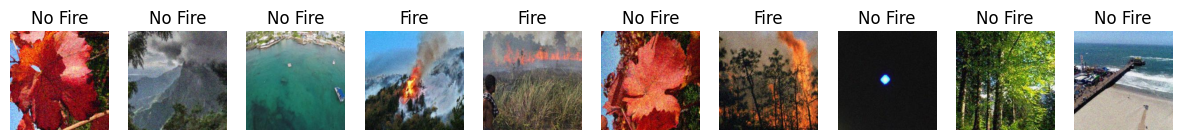

In [21]:
import matplotlib.pyplot as plt

def imshow(image, title):
    """Display image and its title."""
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# Display a few test images with their predictions
num_images_to_show = 10

plt.figure(figsize=(15, 10))

for idx in range(num_images_to_show):
    image, img_path = test_dataset[idx]
    pred = predictions[idx][1]
    label = 'Fire' if pred == 1 else 'No Fire'
    
    plt.subplot(1, num_images_to_show, idx + 1)
    imshow(image, label)

plt.show()
